# Preprocessing of individual datasets
- takes 2-5 minutes total (up to n=4) or 10-15 min (with n=5)
- ironically, the main complication is for datasets which have been FW scaled--noisy reflections are overrepresented near the mean of the Wilson distributions and skew normalization. In the second step of anisotropic scaling I added weights to downweight the effects of noisy reflections.

In [1]:
# General tools
%matplotlib inline
import matplotlib.pyplot as plt
import numpy   as np
import warnings
from mpl_toolkits    import mplot3d
from scipy.stats     import rice, foldnorm, nakagami, gamma 
from scipy.optimize  import least_squares, minimize
from time            import perf_counter

t_overall_start = perf_counter()


Bad key "text.kerning_factor" on line 4 in
C:\Users\Doeke Hekstra\.conda\envs\crystallography\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import reciprocalspaceship as rs
import gemmi
from dw_tools import modify_ds, wilson, plots
from dw_tools import aniso_scaling_step_1 as aniso1
from dw_tools import aniso_scaling_step_2 as aniso2
from dw_tools import knn_tools as knn
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors       import KNeighborsRegressor
rs.__version__

'0.9.5'

In [3]:
%autosave 300
%load_ext autoreload
%autoreload 2

Autosaving every 300 seconds


## Load data

In [4]:
# path="double_wilson_data\\" # Windows
path="double_wilson_data/"    # Unix
data_set_pairs = [("5kvx_phases", "5kw3_phases"),\
                  ("5e1y_phases", "2vwr_phases"),\
                  ("3pyp_phases", "1nwz_phases"),\
                  ("1otb_phases", "1nwz_phases"),\
                  ("4eul_phases", "GFP_1.37A_scaled"),\
#                   "GFP_SSRL_refine_54_final"),\
                  ("4eul_phases", "2y0g_phases"),\
                  ("4kjk_phases", "4kjj_phases", "4pst_phases", "4pss_phases"),\
                  ("e35cdef_OFF200ns_HD_2sig_varEll","e35cdef_200ns_HD_2sig_varEll")]
# example 1 fails on kNN regression
example=4
dataset=1
mtz1 = data_set_pairs[example][dataset] # omit .mtz
ds1 = rs.read_mtz(path + mtz1 + ".mtz")

# cleanup:
unpurged_count = ds1.shape[0];   ds1.dropna(inplace=True)
purged_count   = ds1.shape[0]
print(f"Discarded {unpurged_count-purged_count} out of {unpurged_count} records")

Discarded 0 out of 48817 records


In [5]:
if (example == 4) & (dataset==1): # - GFP_1.37A only contains intensities
    I = ds1["IMEAN"].to_numpy()
    SIGI = ds1["SIGIMEAN"].to_numpy()
    I[I<=0]=0.0001
    ds1["FP"] = np.sqrt(I)
    ds1["SIGFP"] = 0.5*np.sqrt(SIGI**2/I) #I played with using the Nakagami distribution instead, but it seems that its
                                          # std calculation is not very stable
                                          # so using naive error propagation instead.
# if (example == 4) & (dataset==1):
#     ds1["FP"] = ds1["F-obs-filtered"]
#     ds1["SIGFP"] = ds1["SIGF-obs-filtered"]

In [6]:
# modify_ds.merge_anomalous(ds1)
# ds1.loc[ds1["I(+)"]>ds1["I(-)"],["I(+)","SIGI(+)","I(-)","SIGI(-)","IMEAN","SIGIMEAN","I","SIGI"]]

In [7]:
ds1.info()

<class 'reciprocalspaceship.dataset.DataSet'>
MultiIndex: 48817 entries, (0, 0, 2) to (37, 8, 2)
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype                
---  ------           --------------  -----                
 0   FreeR_flag       48817 non-null  MTZInt               
 1   IMEAN            48817 non-null  Intensity            
 2   SIGIMEAN         48817 non-null  Stddev               
 3   I(+)             48817 non-null  FriedelIntensity     
 4   SIGI(+)          48817 non-null  StddevFriedelI       
 5   I(-)             48817 non-null  FriedelIntensity     
 6   SIGI(-)          48817 non-null  StddevFriedelI       
 7   N(+)             48817 non-null  MTZInt               
 8   N(-)             48817 non-null  MTZInt               
 9   rs_a             48817 non-null  MTZReal              
 10  rs_b             48817 non-null  MTZReal              
 11  rs_c             48817 non-null  MTZReal              
 12  dHKL             48817 no

Average observations per bin: 2440.85


(0, 15.747122651338577)

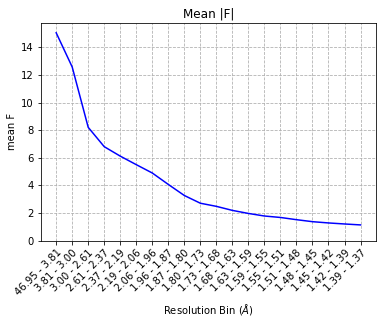

In [8]:
result, bin_labels = plots.compute_meanF_byres(ds1, label="FP", nbins=20,sigma_cut=0)
plots.plot_by_res_bin(result, bin_labels, ylabel="mean F",color='b')
plt.title("Mean |F|")
plt.ylim(0,)

In [9]:
avg = ds1["FP"].mean()
ds1["FP"] = ds1["FP"]/avg
ds1["SIGFP"] = ds1["SIGFP"]/avg

In [10]:
modify_ds.ds_add_rs(ds1)
ds1.compute_dHKL(        inplace=True)
ds1.label_centrics(      inplace=True)
ds1.compute_multiplicity(inplace=True)

FreeR_flag      IMEAN  SIGIMEAN       I(+)   SIGI(+)       I(-)  \
H  K L                                                                     
0  0 2            9  177.79424 7.6636806  177.79424 7.6636806  177.79424   
     4           16    49.9236 3.7112868    49.9236 3.7112868    49.9236   
     6           17  106.04449 5.9179273  106.04449 5.9179273  106.04449   
     8           10  23.522247 2.7722666  23.522247 2.7722666  23.522247   
     10          19  256.79343 10.649977  256.79343 10.649977  256.79343   
...             ...        ...       ...        ...       ...        ...   
37 7 3           17  1.3639202 1.1099159 0.29465702 1.5546688   2.475438   
     4            3  0.5892159 1.2020923   0.981146 1.6732899 0.17120698   
   8 0           19 0.70337415 1.7107347 0.70337415 1.7107347 0.70337415   
     1            3  1.5475854 1.2885407  1.2698382  1.885152  1.7911361   
     2           13 0.24304911 0.5838743 -0.1594955 1.3533399 0.33511227   

          SIGI(-)  N(+)  N(-)      rs_a  ...  CENTRIC  EPSILON  EP_1_aniso_1  \
H  K L                                   ...                                   
0  0 2  7.6636806     4     4       0.0  ...     True        2    0.63686454   
     4  3.7112868     4     4       0.0  ...     True        2     0.3408005   
     6  5.9179273     4     4       0.0  ...     True        2    0.50493807   
     8  2.7722666     4     4       0.0  ...     True        2    0.24341059   
     10 10.649977     4     4       0.0  ...     True        2    0.82899684   
...           ...   ...   ...       ...  ...      ...      ...           ...   
37 7 3  1.5850896     9     5 0.7179921  ...    False        1       0.65944   
     4  1.7280635     8     4 0.7179921  ...    False        1     0.4416772   
   8 0  1.7107347     5     5 0.7179921  ...     True        1    0.45297256   
     1  1.7652912     5     5 0.7179921  ...    False        1     0.6807146   
     2  0.6472064     8     7 0.7179921  ...    False        1    0.27385125   

         SIGEP_1_aniso_1  EP_1_aniso_2  SIGEP_1_aniso_2   EP_1_knn  \
H  K L                                                               
0  0 2       0.013725775     0.7020902      0.015131527 0.71450865   
     4       0.012667439     0.3119391      0.011594671 0.31708747   
     6       0.014089309    0.43292344     0.0120798815  0.4377546   
     8       0.014343846    0.22294614      0.013137905 0.22579917   
     10      0.017190479    0.81870157      0.016976992  0.8215582   
...                  ...           ...              ...        ...   
37 7 3        0.26831594     0.6260582       0.25473344  0.8227489   
     4        0.45054525    0.41750267       0.42588535  0.5458678   
   8 0         0.5508561    0.47234303       0.57441235 0.62025714   
     1         0.2833862     0.6916336       0.28793186  0.9073043   
     2        0.32893494     0.2721846       0.32693306 0.35672283   

         SIGEP_1_knn        FP     SIGFP  
H  K L                                    
0  0 2   0.015399171  3.109089  0.067007  
     4   0.011786033  1.647507  0.061237  
     6   0.012214686  2.401145  0.066999  
     8    0.01330603  1.130873  0.066641  
     10  0.017036228  3.736511  0.077482  
...              ...       ...       ...  
37 7 3    0.33476382  0.272313  0.110800  
     4     0.5568278  0.178983  0.182577  
   8 0    0.75428945  0.195554  0.237812  
     1    0.37771708  0.290069  0.120758  
     2     0.4284757  0.114953  0.138076  

[48817 rows x 23 columns]

### Checking reciprocal space (ASU) coverage
Let's see what chunk of reciprocal space these reflections are located in. 

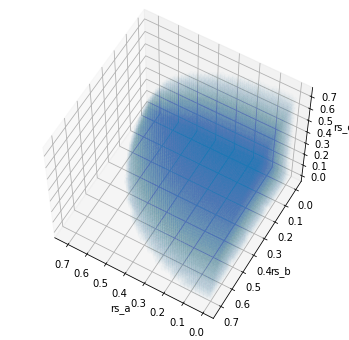

In [11]:
plt.ion
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection="3d")
ax.scatter3D(ds1["rs_a"], ds1["rs_b"], ds1["rs_c"],alpha=0.01)
ax.view_init(elev=60., azim=1200.)
ax.set_xlabel("rs_a")
ax.set_ylabel("rs_b")
ax.set_zlabel("rs_c")
plt.draw()

## Simple anisotropic normalization

In [19]:
# print(np.amin(ds1["FP"].to_numpy()))
# print(np.amax(ds1["FP"].to_numpy()))
# print(np.sum(np.isnan(ds1["FP"].to_numpy())))
res = minimize(         aniso1.anisotropic_scaling_to_1_wilson_loss, [0,0,0,0,0,0,1],\
                                                                method='L-BFGS-B',jac=True,args=(ds1,"FP"))
# res = minimize(         aniso1.anisotropic_scaling_to_1_wilson_loss, [-5,0,0,-5,0,-5,0.25],\
#                                                                 method='nelder-mead',jac=True,args=(ds1,"FP"))
res_test, ep1, sigep1 = aniso1.anisotropic_scaling_to_1_wilson_loss(res.x, ds1, label="FP", nargout=3)
print(res.x)

ds1["EP_1_aniso_1"] = ep1
ds1["SIGEP_1_aniso_1"] = sigep1

[-5.43451248  0.20758041 -0.0378522  -4.89896542 -0.19751351 -5.75112984
  0.21313015]


Inspection of histograms. In the absence of a sigma cutoff, we get significant extra counts around the mode of the distribution. This must be the consequence of FW scaling. When we omit these, we see that the histogram is a bit shifted relative the Wilson distribution, suggesting noisy reflections skewed normalization.

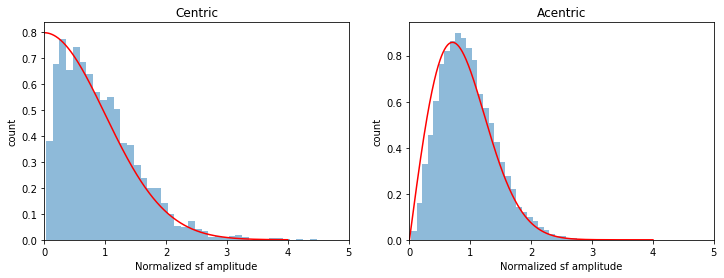

In [20]:
sig_cut = 0.1 # noisy observations deviation significantly from the Wilson distribution!
              # ironically, French-Wilson seems to blame--the reflections with largest error 
              # will tend to get scaled to the mean of the Wilson distribution

x=np.linspace(0,4,500)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(ep1[(ds1["CENTRIC"]==True) & (sigep1<sig_cut)],40,alpha=0.5,density=True)
plt.plot(x,wilson.wilson_dist_normalized(x,centric=True),'r-') 
plt.ylabel("count"); plt.xlabel("Normalized sf amplitude")
plt.xlim([0,5])
plt.title("Centric")

plt.subplot(1,2,2)
plt.hist(ep1[(ds1["CENTRIC"]==False) & (sigep1<sig_cut)],40,alpha=0.5,density=True)
plt.plot(x, wilson.wilson_dist_normalized(x,centric=False),'r-')
plt.ylabel("count"); plt.xlabel("Normalized sf amplitude")
plt.xlim([0,5])
plt.title("Acentric"); 

## Anisotropic normalization with Fourier corrections

Since we're using quite a few parameters, we'll use a test set to choose the optimal order of the Fourier series.


In [21]:
rseed=1763
np.random.seed(rseed)
ds1["test_flag"] = (np.random.random((ds1.shape[0],1)) <0.85)

In [22]:
# typically the minimum is for n=3 or 4...
# see right below for typical run times by n (n=4: 2-3 min total)
# note that at higher values of n sometimes NaNs pop up

res=[0] # start with a dummy so next entries match their n
n_best = 0
best_loss = 9e9
for n in [1,2,3,4,5]:
    t1_start = perf_counter()
    params = aniso2.prepare_for_FFT(ds1, n=n, label="EP_1_aniso_1")
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        init_guess = np.zeros((1,2*(n**3)))
        if n>1:
            init_guess[0,:res[-1].x.shape[0]]=res[-1].x
        else:
            init_guess[0]=np.array([1, 0])
        res_tmp = minimize(aniso2.anisotropic_scaling_to_1_FFT_wilson_loss_fast, \
                           init_guess,method='L-BFGS-B', jac = True, \
                           args=(params,ds1["test_flag"].to_numpy()))
        res.append(res_tmp)
        res_test = aniso2.anisotropic_scaling_to_1_FFT_wilson_loss_fast(res_tmp.x, \
                                          params, bUse=~ds1["test_flag"].to_numpy(), nargout=1)
        if res_test[0] < best_loss:
            best_loss = res_test[0]
            n_best = n
        print(f"For n = {n} the test loss = {res_test[0]:.6}")
        t1_stop = perf_counter()  
        print(f"Elapsed time: {t1_stop-t1_start:.4} s")

For n = 1 the test loss = 5749.05
Elapsed time: 0.382 s
For n = 2 the test loss = 5577.68
Elapsed time: 4.973 s
For n = 3 the test loss = 5512.81
Elapsed time: 36.99 s
For n = 4 the test loss = 5433.7
Elapsed time: 147.6 s
For n = 5 the test loss = 5438.14
Elapsed time: 598.0 s


In [23]:
# run for best n using *all* reflections and save
params = aniso2.prepare_for_FFT(ds1, n=n_best, label="EP_1_aniso_1")

loss, ep1, sigep1, scale1 = aniso2.anisotropic_scaling_to_1_FFT_wilson_loss_fast(res[n_best].x, params, \
                                                        bUse=np.ones((ds1.shape[0],),dtype=bool), nargout=3)

EP1_label = "EP_1_aniso_2"
ds1[EP1_label]   = ep1
ds1["SIG" + EP1_label]= sigep1
print(np.mean(ep1[ds1["CENTRIC"]==True]**2))
print(np.mean(ep1[ds1["CENTRIC"]==False]**2))

0.8297185212274619
0.8163334649388874


Graphical inspection:

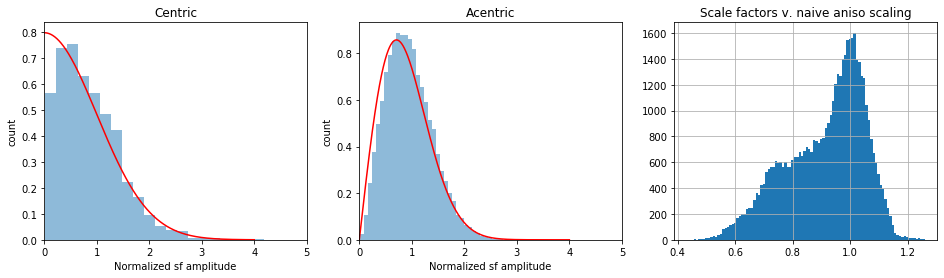

In [24]:
sig_cut = 0.1 # noisy observations deviation significantly from the Wilson distribution!
              # ironically, French-Wilson scaling seems to blame.

x=np.linspace(0,4,500)
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.hist(ep1[(ds1["CENTRIC"]==True) & (sigep1<sig_cut)],20,alpha=0.5,density=True)
plt.plot(x,wilson.wilson_dist_normalized(x,centric=True),'r-') 
plt.ylabel("count"); plt.xlabel("Normalized sf amplitude")
plt.xlim([0,5]); plt.title("Centric")

plt.subplot(1,3,2)
plt.hist(ep1[(ds1["CENTRIC"]==False) & (sigep1<sig_cut)],40,alpha=0.5,density=True)
plt.plot(x, wilson.wilson_dist_normalized(x,centric=False),'r-')
plt.ylabel("count"); plt.xlabel("Normalized sf amplitude")
plt.xlim([0,5]); plt.title("Acentric"); 

plt.subplot(1,3,3)
plt.hist(scale1,100); plt.grid()
plt.title("Scale factors v. naive aniso scaling")
plt.show()

## Normalization by regression estimates of Sigma
We're estimating $<|F|^2>$ locally in reciprocal space! Because the expected intensity is the same for acentric and centric reflections, we can do this in one go for all of them.

By Rupp eq. (7-104): $ \Sigma_N = \left<I\right>/\varepsilon_h $

Below are two implementations of $\Sigma$ estimation: using kernel ridge regression and k-nearest neighbors with custom weights. The former retains more of the correlation among data sets than the latter, but is **much** slower and more memory-intensive. It crashes on the cluster.

In [25]:
temp = ds1["EPSILON"][ds1["CENTRIC"].to_numpy()==True]
print("Distribution of multiplicities for centric reflections:")
print(temp.value_counts())
print("")

temp = ds1["EPSILON"][ds1["CENTRIC"].to_numpy()==False]
print("Distribution of multiplicities for acentric reflections:")
print(temp.value_counts())

Distribution of multiplicities for centric reflections:
1    4538
2      60
Name: EPSILON, dtype: int64

Distribution of multiplicities for acentric reflections:
1    44219
Name: EPSILON, dtype: int64


We now perform k-nearest neighbor regression (with self excluded). The optimal $k$ (and uniform weights) are **much higher** when the input have already been anisotropically scaled. Larger $k$ is also slower...

In [26]:
gridsearch = False 
ncpu=1 #8 worked on the cluster
param_grid={"n_neighbors":[50,100,200,400,800],'weights':['uniform',knn.knn_weight_exp_p05, knn.knn_weight_norm_p05]}
#                                                                   knn.knn_weight_exp_p02, knn.knn_weight_norm_p02, \
#                                                                   knn.knn_weight_exp_p03, knn.knn_weight_norm_p03]}
if gridsearch: 
    knn_1 = GridSearchCV(KNeighborsRegressor(n_jobs=ncpu),param_grid=param_grid)
    knn_1.fit(ds1[["rs_a", "rs_b", "rs_c"]].to_numpy(), (ds1[EP1_label].to_numpy()**2)) # these should be corrected for eps already
else:
    knn_1 = KNeighborsRegressor(800, weights=knn.knn_weight_exp_p05,n_jobs=ncpu)
    knn_1.fit(ds1[["rs_a", "rs_b", "rs_c"]], (ds1[[EP1_label]].to_numpy()**2))

if gridsearch:
    print(knn_1.best_params_)

In [27]:
Sigma_1 = knn_1.predict(ds1[["rs_a", "rs_b", "rs_c"]]).reshape(-1,1)

In [28]:
E1    = ds1[        EP1_label].to_numpy().reshape(-1,1)/np.sqrt(Sigma_1) # We've already taken care of epsilon above
SIGE1 = ds1["SIG" + EP1_label].to_numpy().reshape(-1,1)/np.sqrt(Sigma_1)

ds1["EP_1_knn"]    = E1
ds1["SIGEP_1_knn"] = SIGE1

## Analysis

Average observations per bin: 2440.85
Average observations per bin: 2440.85
Average observations per bin: 2440.85
Average observations per bin: 2440.85


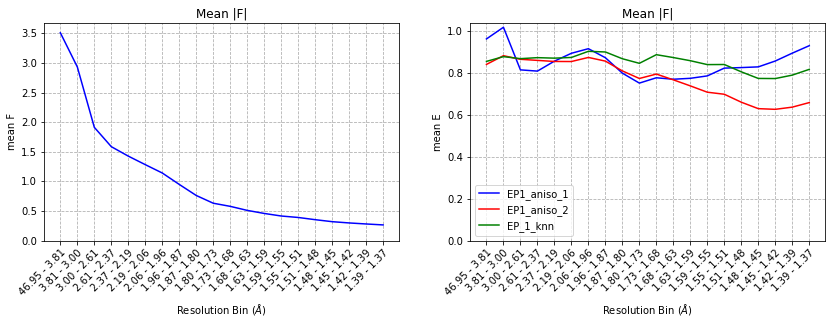

In [29]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
result, bin_labels = plots.compute_meanF_byres(ds1, label="FP", nbins=20,sigma_cut=0)
plots.plot_by_res_bin(result, bin_labels, ylabel="mean F",color='b')
plt.title("Mean |F|")
plt.ylim(0,)

plt.subplot(1,2,2)
result_1, bin_labels_1 = plots.compute_meanF_byres(ds1, label="EP_1_aniso_1", nbins=20,sigma_cut=0)
result_2, bin_labels_2 = plots.compute_meanF_byres(ds1, label="EP_1_aniso_2", nbins=20,sigma_cut=0)
result_3, bin_labels_3 = plots.compute_meanF_byres(ds1, label="EP_1_knn",     nbins=20,sigma_cut=0)
plots.plot_by_res_bin(result_1, bin_labels_1, ylabel="mean E",color='b')
plots.plot_by_res_bin(result_2, bin_labels_2, ylabel="mean E",color='r')
plots.plot_by_res_bin(result_3, bin_labels_2, ylabel="mean E",color='g')
plt.title("Mean |F|")
plt.legend(["EP1_aniso_1", "EP1_aniso_2","EP_1_knn"])
plt.ylim(0,)
plt.show()

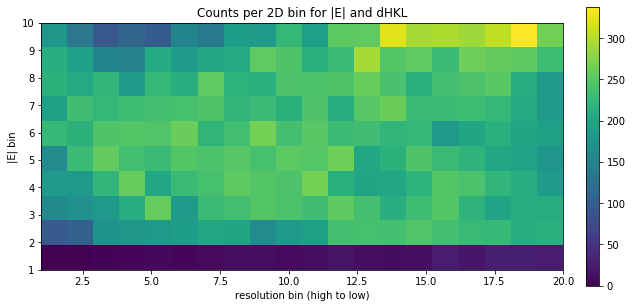

In [30]:
# Let's examine the distribution of dHKL and E in the data
sig_cut = 1
nbin    = (20,10)

cdf_bins     = np.linspace(0,100,nbin[0]+1)
d_bins       = np.percentile(ds1["dHKL"], cdf_bins)
d_bins[-1]   = d_bins[-1]+1e-6   # to avoid omitting the largest data point
d_dig        = np.digitize(ds1["dHKL"], d_bins)
ds1["dHKL_bin"] = d_dig.flatten()
# print(d_bins)

cdf_bins     = np.linspace(0,100,nbin[1]+1)
ep1_bins     = np.percentile(ds1[EP1_label], cdf_bins)
ep1_bins[-1] = ep1_bins[-1]+1e-6 # to avoid omitting the largest data point
ep1_dig      = np.digitize(ds1["EP_1_aniso_2"], ep1_bins)
ds1["EP_1_bin"] = ep1_dig.flatten()

H, xedges, yedges = np.histogram2d(ds1.loc[(ds1["CENTRIC"]==False) & (ds1["SIG" + EP1_label]<sig_cut), "dHKL_bin"], \
                                   ds1.loc[(ds1["CENTRIC"]==False) & (ds1["SIG" + EP1_label]<sig_cut), "EP_1_bin"],bins=nbin)

plt.figure(figsize=(10,8))
im=plt.imshow(H.transpose(), interpolation='nearest', origin='lower',\
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],vmin=0)
plt.xlabel("resolution bin (high to low)")
plt.ylabel("|E| bin")
plt.title("Counts per 2D bin for |E| and dHKL")
plt.colorbar(im,fraction=0.025, pad=0.04)

fname = mtz1 + "_n" + str(n_best) + "_" + EP1_label + "_" + str(rseed)+ ".png"
plt.savefig("results_figs/" + fname)
plt.show()

## Cleaning up 

In [ ]:
ds1["rs_a"]           = ds1["rs_a"           ].astype("MTZReal")
ds1["rs_b"]           = ds1["rs_b"           ].astype("MTZReal")
ds1["rs_c"]           = ds1["rs_c"           ].astype("MTZReal")
ds1["EP_1_aniso_1"]   = ds1["EP_1_aniso_1"   ].astype("NormalizedSFAmplitude")
ds1["EP_1_aniso_2"]   = ds1["EP_1_aniso_2"   ].astype("NormalizedSFAmplitude")
ds1["EP_1_knn"]       = ds1["EP_1_knn"       ].astype("NormalizedSFAmplitude")
ds1["SIGEP_1_aniso_1"]= ds1["SIGEP_1_aniso_1"].astype("Stddev")
ds1["SIGEP_1_aniso_2"]= ds1["SIGEP_1_aniso_2"].astype("Stddev")
ds1["SIGEP_1_knn"]    = ds1["SIGEP_1_knn"    ].astype("Stddev")
# ds1.info()

Let's check whether we still have unsupported column datatypes around!

In [ ]:
modify_ds.check_col_dtypes(ds1)

In [ ]:
# We'll have to add centric flags back later
ds1.write_mtz(path + mtz1 + "_scaled.mtz",skip_problem_mtztypes=True)
t_overall_end = perf_counter()
print("Total elapsed time:", t_overall_end-t_overall_start)

## Obsolete stuff

In [ ]:
mu = 4.5
var = 0.5**2
theta = var/mu
k = mu/theta
m = k
Om = m*theta
std = nakagami.std(m, loc=0, scale=np.sqrt(Om))
x = gamma.rvs(a=k, scale=theta, size=10000)
base=np.linspace(0,12,1000)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(x,50,density=True)
plt.plot(base, gamma.pdf(x=base, a=k, scale=theta),'r-')
plt.title(r"Histogram for x."); plt.xlim([0,10])

plt.subplot(1,2,2)
plt.hist(np.sqrt(x),50,density=True)
print(np.mean(x))
plt.plot(base, nakagami.pdf(x=base, nu=k, scale=np.sqrt(Om)),'r-')
plt.title(r"Histogram for $\sqrt{x}$."); plt.xlim([0,5])
plt.show()